In [131]:
import pandas as pd
import numpy as np
import scanpy as sc
import os

In [133]:
import seaborn as sns
import scvi

In [135]:
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)
ribo_genes

,0
0,FAU
1,MRPL13
2,RPL10
3,RPL10A
4,RPL10L
...,...
83,RPS9
84,RPSA
85,RSL24D1
86,RSL24D1P11


# Preprocessing

In [137]:
def pp(csv_path):
    adata = sc.read_csv(csv_path).T
    sc.pp.filter_genes(adata, min_cells = 10)
    sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train()
    df = solo.predict()
    df['prediction'] = solo.predict(soft = False)
    df.index = df.index.map(lambda x: x[:-2])
    df['dif'] = df.doublet - df.singlet
    doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]
    
    adata = sc.read_csv(csv_path).T
    adata.obs['Sample'] = csv_path.split('_')[2] #'raw_counts/GSM5226574_C51ctr_raw_counts.csv'
    
    adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
    adata = adata[~adata.obs.doublet]
    
    
    sc.pp.filter_cells(adata, min_genes=200) #get rid of cells with fewer than 200 genes
    #sc.pp.filter_genes(adata, min_cells=3) #get rid of genes that are found in fewer than 3 cells
    adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
    adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    adata = adata[adata.obs.n_genes_by_counts < upper_lim]
    adata = adata[adata.obs.pct_counts_mt < 20]
    adata = adata[adata.obs.pct_counts_ribo < 2]

    return adata

In [ ]:
out = []
for file in os.listdir('lung_data/'):
    out.append(pp('lung_data/' + file))
adata = sc.concat(out)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/ananya/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/ananya/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████| 400/400 [04:56<00:00,  1.13s/it, v_num=1, train_loss_step=276, train_loss_epoch=257]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████| 400/400 [04:56<00:00,  1.35it/s, v_num=1, train_loss_step=276, train_loss_epoch=257]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/ananya/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/ananya/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/ananya/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 244/400:  61%|████████████████████████████████████████████████▊                               | 244/400 [00:28<00:18,  8.61it/s, v_num=1, train_loss_step=0.251, train_loss_epoch=0.277]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.279. Signaling Trainer to stop.


/Users/ananya/anaconda3/lib/python3.11/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/ananya/anaconda3/lib/python3.11/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/ananya/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = nu

Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████| 400/400 [08:08<00:00,  1.03s/it, v_num=1, train_loss_step=348, train_loss_epoch=323]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████| 400/400 [08:08<00:00,  1.22s/it, v_num=1, train_loss_step=348, train_loss_epoch=323]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/ananya/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/ananya/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/ananya/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 243/400:  61%|████████████████████████████████████████████████▌                               | 243/400 [00:39<00:25,  6.20it/s, v_num=1, train_loss_step=0.331, train_loss_epoch=0.297]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.267. Signaling Trainer to stop.


/Users/ananya/anaconda3/lib/python3.11/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/ananya/anaconda3/lib/python3.11/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/ananya/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = nu

Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████| 400/400 [05:26<00:00,  1.24it/s, v_num=1, train_loss_step=360, train_loss_epoch=396]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████| 400/400 [05:26<00:00,  1.22it/s, v_num=1, train_loss_step=360, train_loss_epoch=396]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/ananya/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/ananya/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/ananya/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 212/400:  53%|██████████████████████████████████████████▍                                     | 212/400 [00:29<00:26,  7.16it/s, v_num=1, train_loss_step=0.462, train_loss_epoch=0.302]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.328. Signaling Trainer to stop.


/Users/ananya/anaconda3/lib/python3.11/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/ananya/anaconda3/lib/python3.11/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/ananya/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = nu

Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████| 400/400 [08:13<00:00,  1.17s/it, v_num=1, train_loss_step=265, train_loss_epoch=333]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████| 400/400 [08:13<00:00,  1.23s/it, v_num=1, train_loss_step=265, train_loss_epoch=333]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/ananya/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/ananya/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/ananya/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 287/400:  72%|█████████████████████████████████████████████████████████▍                      | 287/400 [00:51<00:20,  5.61it/s, v_num=1, train_loss_step=0.156, train_loss_epoch=0.311]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.303. Signaling Trainer to stop.


/Users/ananya/anaconda3/lib/python3.11/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/ananya/anaconda3/lib/python3.11/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/ananya/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = nu

Epoch 341/400:  85%|███████████████████████████████████████████████████████████████████████▍            | 340/400 [05:04<01:11,  1.19s/it, v_num=1, train_loss_step=432, train_loss_epoch=475]

In [ ]:
import random
random.seed(0)

In [ ]:
sc.pp.filter_genes(adata, min_cells = 10)
from scipy.sparse import csr_matrix 
adata.X = csr_matrix(adata.X)

In [ ]:
adata.write_h5ad('combined.h5ad')

In [ ]:
adata

In [ ]:
adata.obs

In [ ]:
adata.var

In [ ]:
adata.obs.groupby('Sample').count()

# Filtering 

In [48]:
sc.pp.filter_genes(adata, min_cells = 100)
adata

AnnData object with n_obs × n_vars = 5960 × 9921
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'

In [50]:
adata.layers['counts'] = adata.X.copy()

In [54]:
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [58]:
adata.obs.head()

,Sample,doublet,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
CGTTCTGGTACTAGCT-1_1,C51ctr,False,2434,2434,6047.0,0.0,0.0,1.0,0.016537
CTGGCAGGTTCGGTAT-1_1,C51ctr,False,2444,2444,5899.0,0.0,0.0,5.0,0.084760
ACACCAACACAACGCC-1_1,C51ctr,False,2451,2451,5497.0,0.0,0.0,3.0,0.054575
CCTCAACCATACAGGG-1_1,C51ctr,False,2276,2276,5434.0,0.0,0.0,0.0,0.000000
ACAAAGATCCACAGGC-1_1,C51ctr,False,2310,2310,5504.0,0.0,0.0,1.0,0.018169


In [60]:
adata

AnnData object with n_obs × n_vars = 5960 × 9921
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'
    uns: 'log1p'
    layers: 'counts'

In [62]:
# sc.pp.highly_variable_genes(adata, n_top_genes=3000, subset = True, layer = 'counts',
#                            flavor = "seurat_v3", batch_key="Sample") #no batch_key if one sample

In [65]:
sc.pp.highly_variable_genes(adata, n_top_genes=3000, subset = True, layer = 'counts',
                            flavor = "seurat_v3") #no batch_key if one sample

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [67]:
scvi.model.SCVI.setup_anndata(adata, layer = "counts",
                             categorical_covariate_keys=["Sample"],
                             continuous_covariate_keys=['pct_counts_mt', 'total_counts', 'pct_counts_ribo'])

In [69]:
model = scvi.model.SCVI(adata)

In [71]:
model.train() #may take a while without GPU

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/ananya/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/ananya/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████| 400/400 [09:49<00:00,  1.28s/it, v_num=1, train_loss_step=753, train_loss_epoch=693]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████| 400/400 [09:49<00:00,  1.47s/it, v_num=1, train_loss_step=753, train_loss_epoch=693]


In [72]:
adata.obsm['X_scVI'] = model.get_latent_representation()

In [73]:
adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)

In [74]:
sc.pp.neighbors(adata, use_rep = 'X_scVI')

In [75]:
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.5)

/var/folders/_5/577czd8n0h98rgb9kmt_kh2c0000gn/T/ipykernel_1167/4004962361.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = 0.5)


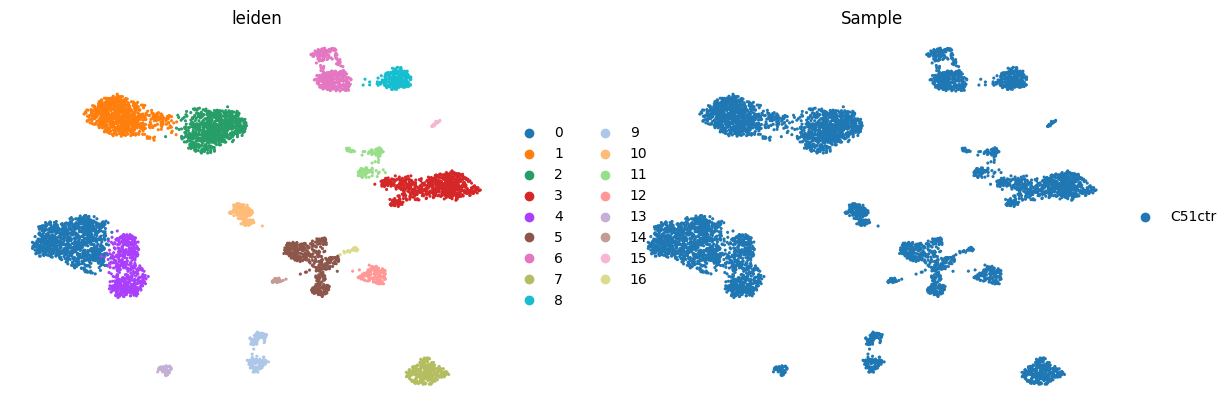

In [76]:
sc.pl.umap(adata, color = ['leiden', 'Sample'], frameon = False)

In [77]:
adata.write_h5ad('integrated.h5ad')

# Find markers/cell types

In [100]:
sc.tl.leiden(adata,resolution = 1)

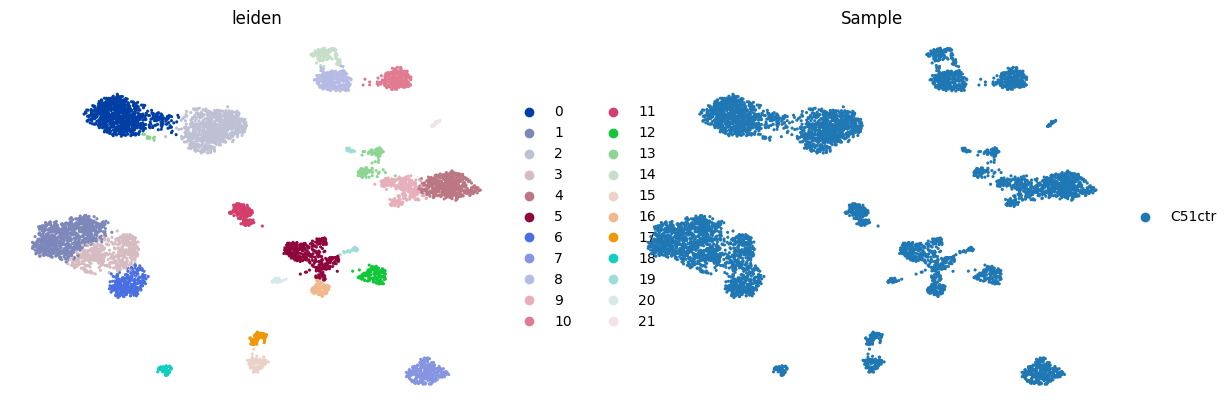

In [102]:
sc.pl.umap(adata, color = ['leiden', 'Sample'], frameon = False)

In [104]:
sc.tl.rank_genes_groups(adata, 'leiden')

/Users/ananya/anaconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/Users/ananya/anaconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/Users/ananya/anaconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:440: PerformanceWarning: DataFrame is highly 

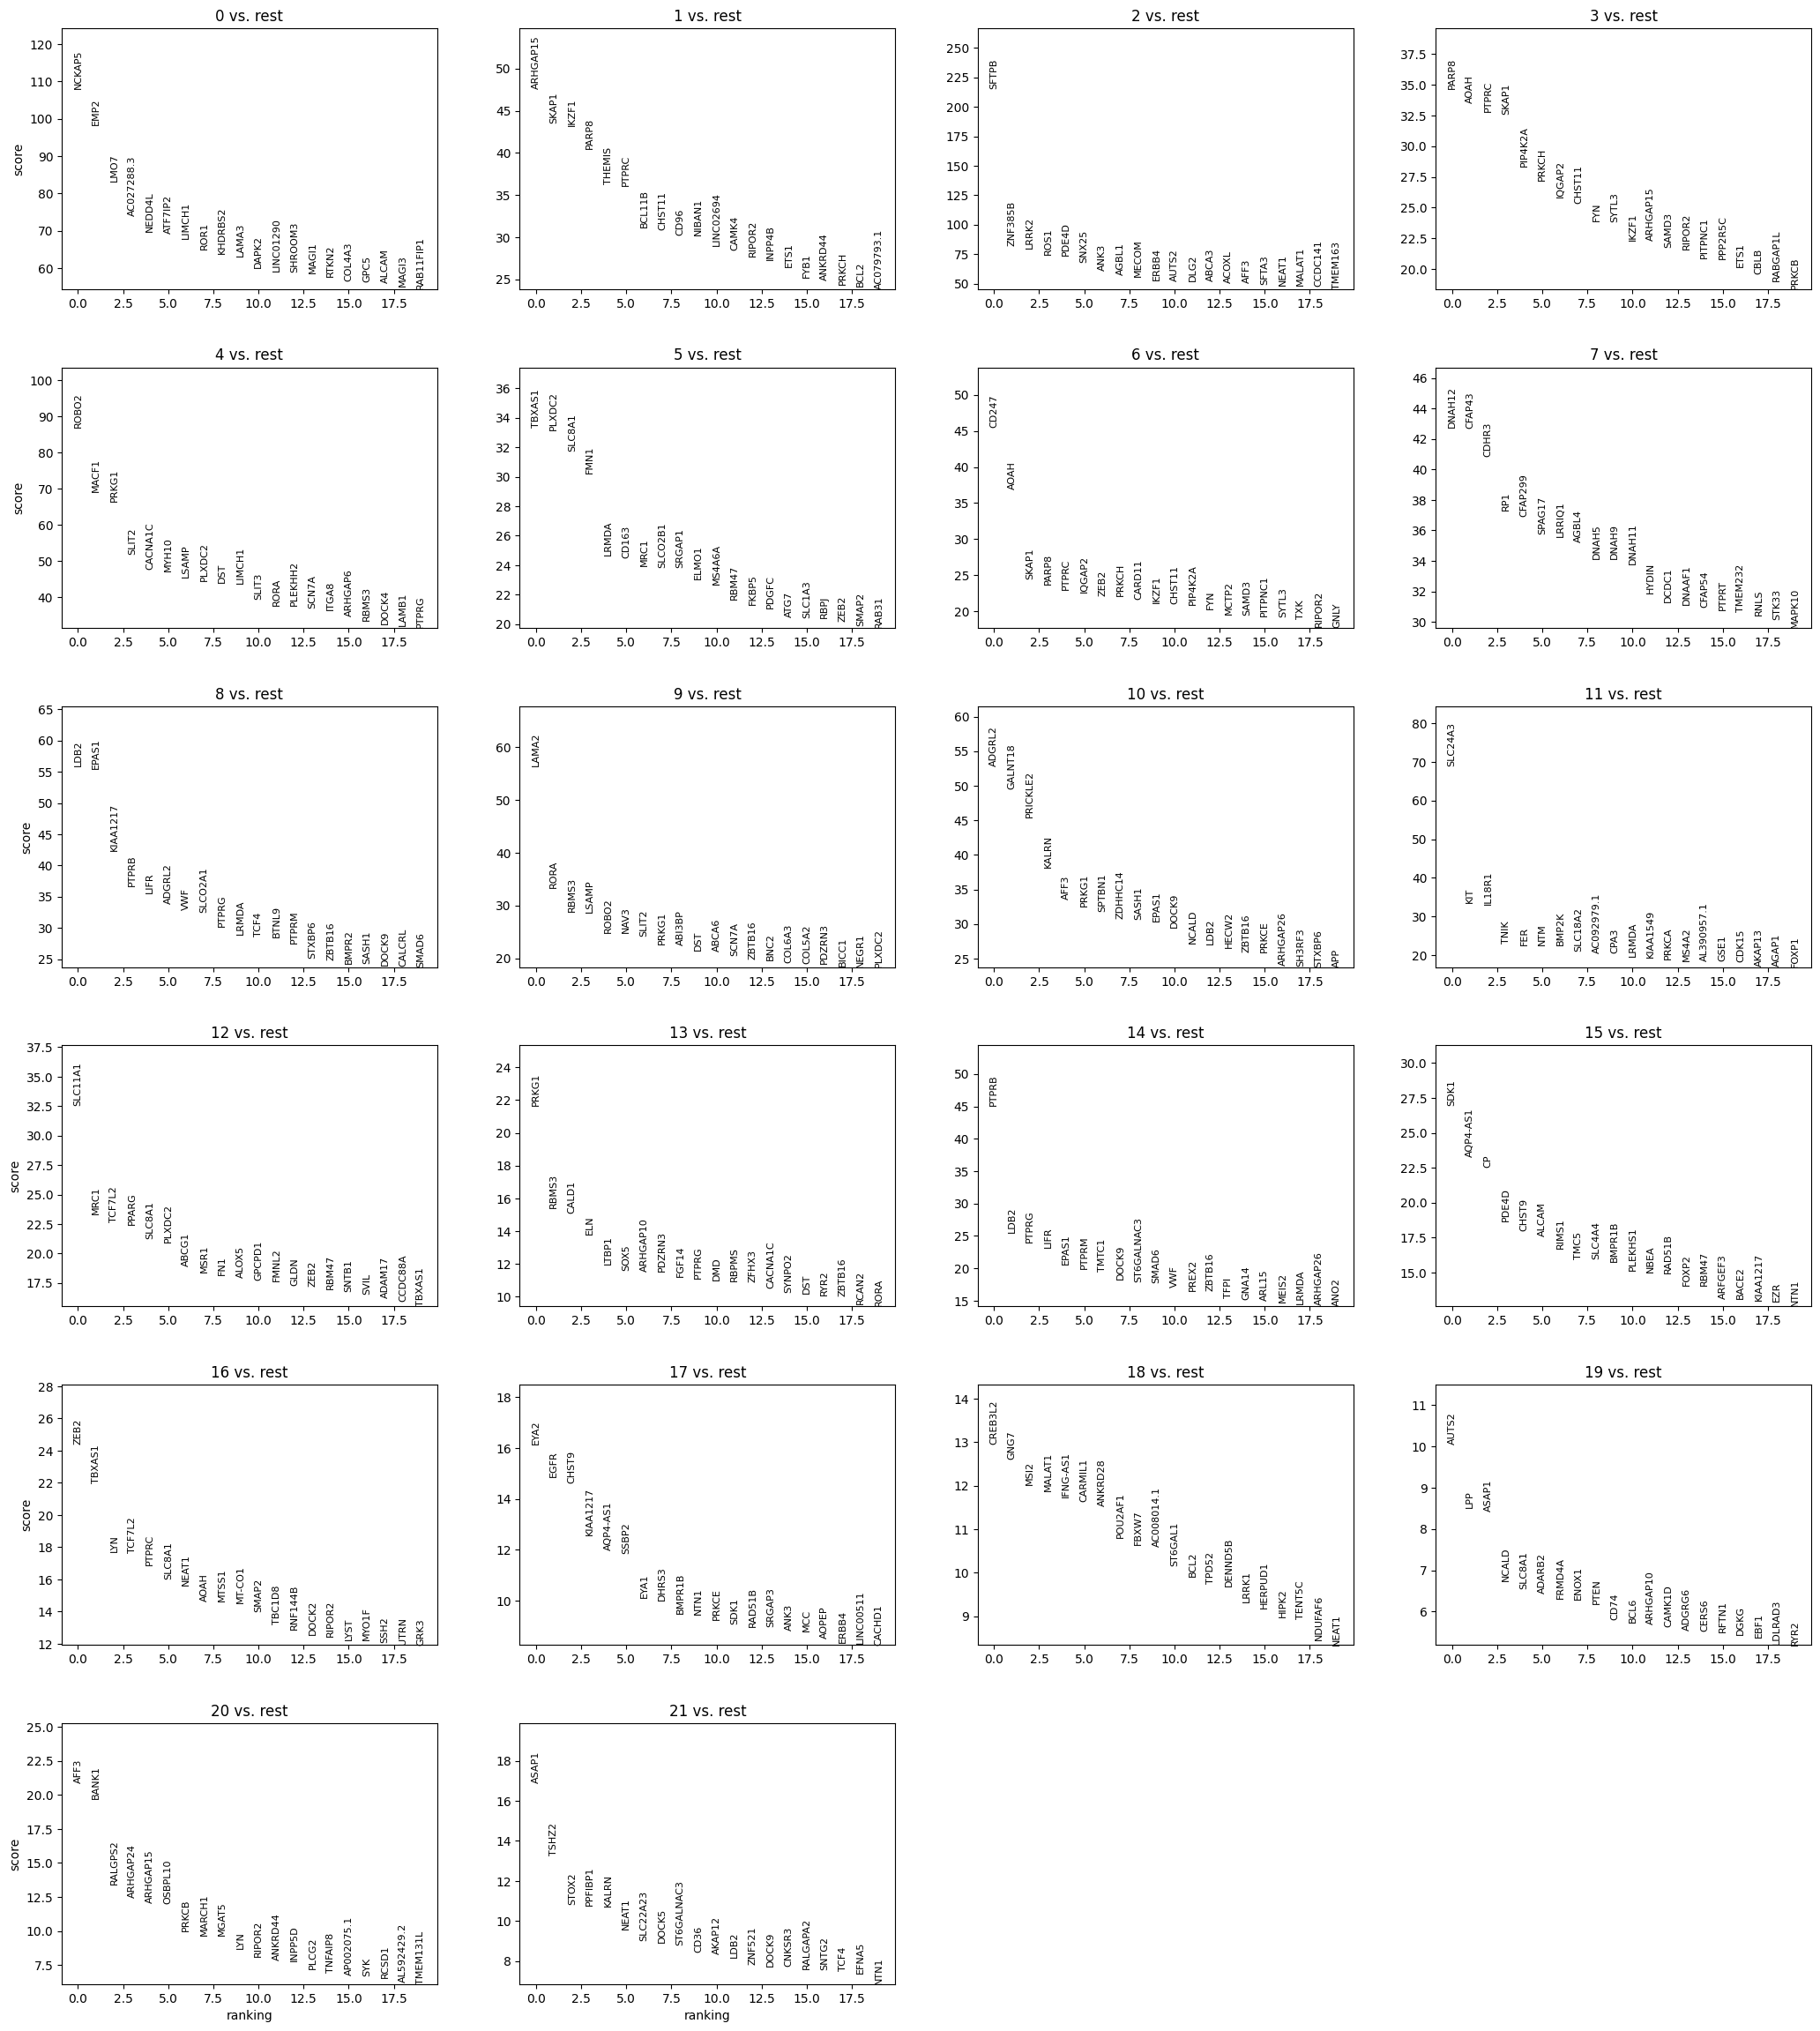

In [107]:
sc.pl.rank_genes_groups(adata, n_genes=20, sharey = False) 

In [109]:
markers = sc.get.rank_genes_groups_df(adata, None)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > .5)]
markers

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,NCKAP5,108.085785,8.120450,0.000000,0.000000
1,0,EMP2,98.311577,7.720970,0.000000,0.000000
2,0,LMO7,83.198448,6.166324,0.000000,0.000000
3,0,AC027288.3,74.065247,7.729941,0.000000,0.000000
4,0,NEDD4L,69.796219,5.110842,0.000000,0.000000
...,...,...,...,...,...,...
208563,21,EMCN,2.452964,3.011817,0.020184,0.048044
208564,21,SGSM1,2.449847,3.055204,0.020333,0.048386
208565,21,FGD5,2.442468,2.460786,0.020672,0.049147
208566,21,TNS1,2.442251,1.402408,0.020655,0.049117


In [111]:
markers_scvi = model.differential_expression(groupby = 'leiden')
markers_scvi

DE...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:18<00:00,  1.19it/s]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
SCEL,1.0000,0.0000,18.420681,0.003654,0.000056,0.0,0.25,9.165834,8.920299,3.824151,...,3.060647,0.014847,0.801427,0.009377,39.468803,0.173915,True,0 vs Rest,0,Rest
GPRC5D-AS1,1.0000,0.0000,18.420681,0.002674,0.000066,0.0,0.25,8.134736,7.733485,3.613246,...,2.248516,0.032819,0.705113,0.027935,29.900360,0.498688,True,0 vs Rest,0,Rest
AC027288.3,0.9998,0.0002,8.516943,0.006351,0.000162,0.0,0.25,9.295274,8.847555,4.564710,...,4.982176,0.060754,0.909631,0.037703,67.827888,0.961816,True,0 vs Rest,0,Rest
ANKRD29,0.9998,0.0002,8.516943,0.001784,0.000058,0.0,0.25,9.044279,7.932557,5.224658,...,1.382883,0.030475,0.677765,0.026568,18.405151,0.457227,True,0 vs Rest,0,Rest
AL355499.1,0.9998,0.0002,8.516943,0.003401,0.000033,0.0,0.25,9.613313,9.466118,3.494677,...,2.750301,0.001367,0.791914,0.000195,36.277287,0.010957,True,0 vs Rest,0,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LINC02018,0.7890,0.2110,1.318908,0.000256,0.000275,0.0,0.25,0.152367,0.182806,0.972434,...,0.129032,0.111316,0.096774,0.084331,2.244361,2.082016,False,21 vs Rest,21,Rest
CFAP44,0.7842,0.2158,1.290312,0.000267,0.000345,0.0,0.25,-0.069576,-0.018806,1.087295,...,0.096774,0.219261,0.096774,0.136111,3.805840,3.805131,False,21 vs Rest,21,Rest
CSPP1,0.7816,0.2184,1.275015,0.000494,0.000645,0.0,0.25,-0.163557,-0.110173,1.002198,...,0.290323,0.312529,0.225806,0.203070,5.935760,6.553072,False,21 vs Rest,21,Rest
FILIP1L,0.7752,0.2248,1.237910,0.000577,0.000584,0.0,0.25,0.176751,0.168312,0.920650,...,0.322581,0.258054,0.258065,0.169674,9.232770,6.303025,False,21 vs Rest,21,Rest


In [112]:
markers_scvi = markers_scvi[(markers_scvi['is_de_fdr_0.05']) & (markers_scvi.lfc_mean > .5)]
markers_scvi

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
SCEL,1.0000,0.0000,18.420681,0.003654,0.000056,0.0,0.25,9.165834,8.920299,3.824151,...,3.060647,0.014847,0.801427,0.009377,39.468803,0.173915,True,0 vs Rest,0,Rest
GPRC5D-AS1,1.0000,0.0000,18.420681,0.002674,0.000066,0.0,0.25,8.134736,7.733485,3.613246,...,2.248516,0.032819,0.705113,0.027935,29.900360,0.498688,True,0 vs Rest,0,Rest
AC027288.3,0.9998,0.0002,8.516943,0.006351,0.000162,0.0,0.25,9.295274,8.847555,4.564710,...,4.982176,0.060754,0.909631,0.037703,67.827888,0.961816,True,0 vs Rest,0,Rest
ANKRD29,0.9998,0.0002,8.516943,0.001784,0.000058,0.0,0.25,9.044279,7.932557,5.224658,...,1.382883,0.030475,0.677765,0.026568,18.405151,0.457227,True,0 vs Rest,0,Rest
AL355499.1,0.9998,0.0002,8.516943,0.003401,0.000033,0.0,0.25,9.613313,9.466118,3.494677,...,2.750301,0.001367,0.791914,0.000195,36.277287,0.010957,True,0 vs Rest,0,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CDKL5,0.8888,0.1112,2.078542,0.000483,0.000350,0.0,0.25,0.933485,0.938985,1.451426,...,0.225806,0.184179,0.129032,0.125991,7.447214,2.816230,True,21 vs Rest,21,Rest
KLF6,0.8886,0.1114,2.076520,0.000974,0.000696,0.0,0.25,0.967900,0.886658,1.619852,...,0.903226,0.281328,0.483871,0.180132,22.763321,7.201619,True,21 vs Rest,21,Rest
CCDC40,0.8884,0.1116,2.074501,0.000102,0.000132,0.0,0.25,2.168227,0.238320,4.491280,...,0.000000,0.088379,0.000000,0.063586,0.000000,1.231594,True,21 vs Rest,21,Rest
JUN,0.8880,0.1120,2.070473,0.000242,0.000221,0.0,0.25,2.239688,0.711128,3.826088,...,0.032258,0.099848,0.032258,0.078934,0.935016,1.950297,True,21 vs Rest,21,Rest


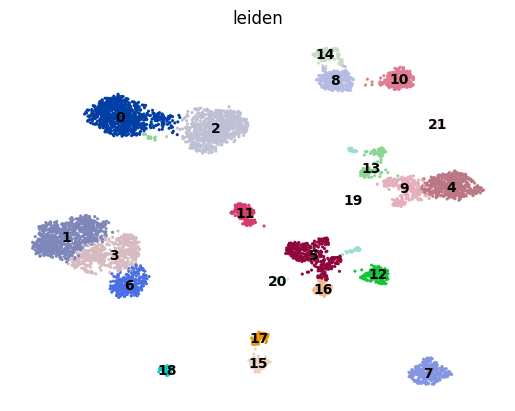

In [115]:
sc.pl.umap(adata, color = ['leiden'], frameon = False, legend_loc = "on data")

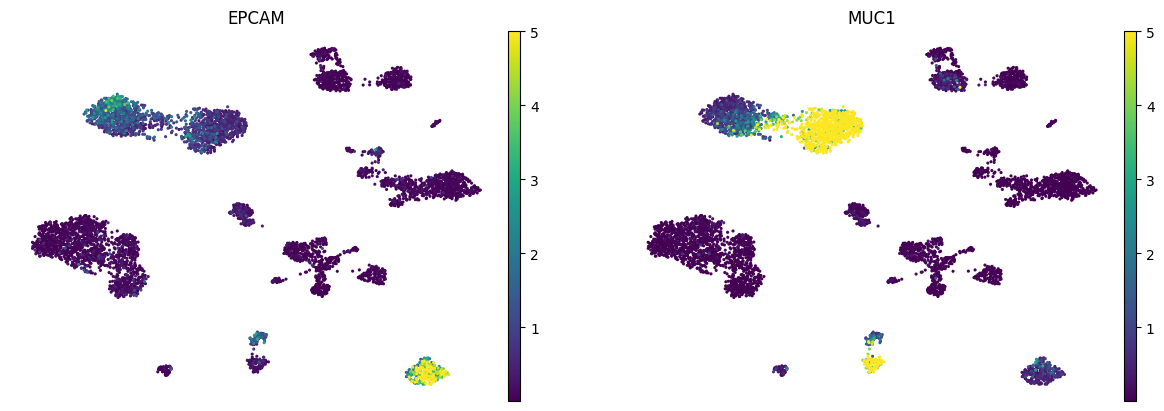

In [129]:
sc.pl.umap(adata, color = ['EPCAM', 'MUC1'], frameon = False, layer = 'scvi_normalized', vmax = 5)
#, layer = 'scvi_normalized'